In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.005

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [19]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None

    def get_added_rects(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


<IPython.core.display.Javascript object>


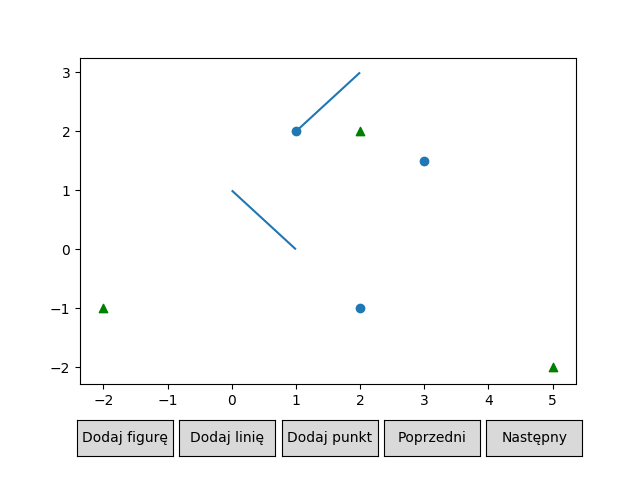

In [9]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


## Structures

In [20]:
from sortedcontainers import SortedSet

scenes = []

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __hash__(self):
        return hash((self.x, self.y))

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.y < other.y)

    def is_above(self, line):
        return self.y > line.a*self.x + line.b
    
    def to_list(self):
        return [self.x, self.y]


class Line:
    def __init__(self, p1, p2):
        if not isinstance(p1, Point):
            p1 = Point(p1[0], p1[1])

        if not isinstance(p2, Point):
            p2 = Point(p2[0], p2[1])

        self.p1 = min(p1, p2)
        self.p2 = max(p1, p2)
        
        self.a = (p2.y - p1.y) / (p2.x - p1.x)  # współczynnik kierunkowy
        self.b = p1.y - ((p2.y - p1.y) * p1.x) / (p2.x - p1.x)  # wyraz wolny

    def __hash__(self):
        return hash((self.p1, self.p2))

    def __eq__(self, other):
        return self.p1 == other.p1 and self.p2 == other.p2

    def __lt__(self, other):
        return self.p1 < other.p1 or (self.p1 == other.p1 and self.p2 < other.p2)

    def print_line(self):
        print("[[{}, {}], [{}, {}]]".format(self.p1.x, self.p1.y, self.p2.x, self.p2.y))
    
    def to_list(self):
        return [self.p1.to_list(), self.p2.to_list()]


class Polygon:
    def __init__(self, points):
        self.points = points
        self.lines = []
        self.make_lines()

    def make_lines(self):
        points = self.points
        lines = []

        for i in range(len(points)):
            lines.append(Line(points[i], points[(i+1) % len(points)]))

        self.lines = lines


class Area:
    def __init__(self, top_line, but_line, left_p, right_p):
        self.top_line = top_line
        self.but_line = but_line
        self.right_p = right_p
        self.left_p = left_p

        self.top_right = None
        self.but_right = None

        self.top_left = None
        self.but_left = None

    def __eq__(self, other):
        if not isinstance(other, Area):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.top_line == self.top_line and self.left_p == self.left_p and self.right_p == self.right_p and self.but_line == other.but_line

    def print_area(self):
        self.top_line.print_line()
        self.but_line.print_line()
        print(self.left_p.x, self.left_p.y)
        print(self.right_p.x, self.right_p.y)
        print()

## Preparing data

In [21]:
def make_polygons_from_json(file_name):
    polygons = []
    with open(file_name, 'r') as file:
        json_polygons = file.read()

    json_polygons = js.loads(json_polygons)

    for polygon in json_polygons:
        polygons.append(Polygon(polygon))

    return polygons


def make_lines_from_json(file_name):
    lines = []
    with open(file_name, 'r') as file:
        json_lines = file.read()

    json_lines = js.loads(json_lines)

    for line in json_lines:
        lines.append(Line(line[0], line[1]))

    return lines

def extract_all_lines(polygons):
    lines = SortedSet()
    for polygon in polygons:
        for line in polygon.lines:
            if line not in lines:
                lines.add(line)

    lines_list = []
    while lines:
        lines_list.append(lines.pop())

    return lines_list


def follow_segment(start_area, line):
    j = 0
    areas = [start_area]
    while line.p2.x > areas[j].right_p.x:
        if areas[j].right_p.is_above(line):
            areas.append(areas[j].but_right)
        else:
            areas.append(areas[j].top_right)
        j += 1

    return areas

## Updating Map

In [146]:
from sortedcontainers import SortedSet
import json


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __hash__(self):
        return hash((self.x, self.y))

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.y < other.y)

    def is_above(self, line):
        p2, p1 = max(line.p1, line.p2), min(line.p1, line.p2)

        a = (p2.y - p1.y) / (p2.x - p1.x)  # współczynnik kierunkowy
        b = p1.y - ((p2.y - p1.y) * p1.x) / (p2.x - p1.x)  # wyraz wolny

        return self.y > a*self.x + b

    def to_list(self):
        return [self.x, self.y]

class Line:
    def __init__(self, p1, p2):
        if not isinstance(p1, Point):
            p1 = Point(p1[0], p1[1])

        if not isinstance(p2, Point):
            p2 = Point(p2[0], p2[1])

        self.p1 = min(p1, p2)
        self.p2 = max(p1, p2)
        
        if p2.x - p1.x == 0:
            self.a = 0
            self.b = 0
        else:
            self.a = (p2.y - p1.y) / (p2.x - p1.x)  # współczynnik kierunkowy
            self.b = p1.y - ((p2.y - p1.y) * p1.x) / (p2.x - p1.x)  # wyraz wolny

        self.polygon = None

    def __hash__(self):
        return hash((self.p1, self.p2))

    def __eq__(self, other):
        return self.p1 == other.p1 and self.p2 == other.p2

    def __lt__(self, other):
        return self.p1 < other.p1 or (self.p1 == other.p1 and self.p2 < other.p2)

    def print_line(self):
        print("[[{}, {}], [{}, {}]]".format(self.p1.x, self.p1.y, self.p2.x, self.p2.y))
        
    def to_list(self):
        return [self.p1.to_list(), self.p2.to_list()]


class Polygon:
    def __init__(self, points):
        self.points = points
        self.lines = []
        self.make_lines()

    def make_lines(self):
        points = self.points
        lines = []

        for i in range(len(points)):
            lines.append(Line(points[i], points[(i+1) % len(points)]))

        self.lines = lines


class Area:
    def __init__(self, top_line, but_line, left_p, right_p):
        self.top_line = top_line
        self.but_line = but_line
        self.right_p = right_p
        self.left_p = left_p

        self.top_right = None
        self.but_right = None

        self.top_left = None
        self.but_left = None

    def __eq__(self, other):
        if not isinstance(other, Area):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.top_line == other.top_line and self.left_p == other.left_p and self.right_p == other.right_p and self.but_line == other.but_line

    def print_area(self):
        self.top_line.print_line()
        self.but_line.print_line()
        print(self.left_p.x, self.left_p.y)
        print(self.right_p.x, self.right_p.y)
        print()


def make_polygons_from_json(file_name):
    polygons = []
    with open(file_name, 'r') as file:
        json_polygons = file.read()

    json_polygons = json.loads(json_polygons)

    for polygon in json_polygons:
        polygons.append(Polygon(polygon))

    return polygons


def make_lines_from_json(file_name):
    lines = []
    with open(file_name, 'r') as file:
        json_lines = file.read()

    json_lines = json.loads(json_lines)

    for line in json_lines:
        lines.append(Line(line[0], line[1]))

    return lines

def extract_all_lines(polygons):
    lines = SortedSet()
    for polygon in polygons:
        for line in polygon.lines:
            if line not in lines:
                line.polygon = polygon
                lines.add(line)

    lines_list = []
    while lines:
        lines_list.append(lines.pop())

    return lines_list


def follow_segment(start_area, line):
    j = 0
    areas = [start_area]
    while line.p2.x > areas[j].right_p.x:
        if areas[j].right_p.is_above(line):
            areas.append(areas[j].but_right)
        else:
            areas.append(areas[j].top_right)
        j += 1

    return areas


def update_map(start_area, line):
    old_areas = follow_segment(start_area, line)  # finding all areas crossed by the line
    new_areas = []  # areas which will override old areas

    p = line.p1  # start point of the line
    q = line.p2  # end point of the line

    top_area = Area(start_area.top_line, line, p, start_area.right_p)  # variable with current area above the line
    but_area = Area(line, start_area.but_line, p, start_area.right_p)  # variable with current area below the line

    if not start_area.left_p == p:  # when start of the line is not part of any other line
        left_area = Area(start_area.top_line, start_area.but_line, start_area.left_p, p)  # area on the left of line

        # checking left side of start area
        if start_area.top_left:  # top left
            left_area.top_left = start_area.top_left

            if start_area.top_left.top_right == start_area:
                start_area.top_left.top_right = left_area

            if start_area.top_left.but_right == start_area:
                start_area.top_left.but_right = left_area

        if start_area.but_left:  # but left
            left_area.but_left = start_area.but_left

            if start_area.but_left.top_right == start_area:
                start_area.but_left.top_right = left_area

            if start_area.but_left.but_right == start_area:
                start_area.but_left.but_right = left_area

        # checking right side of start area
        left_area.top_right = top_area  # connections from left area
        left_area.but_right = but_area

        top_area.top_left = left_area   # connections to left area
        top_area.but_left = left_area
        but_area.top_left = left_area
        but_area.but_left = left_area

        new_areas.append(left_area)  # adding area to the list

    else:  # if start point is a part of other line
        if not top_area.top_line.p1 == top_area.but_line.p1:
            if start_area.top_left.top_right == start_area:
                start_area.top_left.top_right = top_area
            if start_area.top_left.but_right == start_area:
                start_area.top_left.but_right = top_area

            top_area.top_left = start_area.top_left
            top_area.but_left = start_area.top_left

        if not but_area.top_line.p1 == but_area.but_line.p1:
            if start_area.but_left.top_right == start_area:
                start_area.but_left.top_right = but_area
            if start_area.but_left.but_right == start_area:
                start_area.but_left.but_right = but_area

            but_area.top_left = start_area.but_left
            but_area.but_left = start_area.but_left

    for i in range(1, len(old_areas)):  # for every area crossed by the line
        if top_area.right_p.is_above(line):  # last old area has right_p above the line
            new_top_area = Area(old_areas[i].top_line, line,
                                old_areas[i].left_p, old_areas[i].right_p)  # new area on the right

            if top_area.top_line.p2 == top_area.right_p:  # top right of top area
                top_area.top_right = new_top_area
            else:
                top_area.top_right = old_areas[i].top_left.top_right

                if old_areas[i].top_left.top_right.top_left == old_areas[i].top_left:
                    old_areas[i].top_left.top_right.top_left = top_area

                if old_areas[i].top_left.top_right.but_left == old_areas[i].top_left:
                    old_areas[i].top_left.top_right.but_left = top_area

            if new_top_area.top_line.p1 == new_top_area.left_p:  # top left of new top area
                new_top_area.top_left = top_area
            else:
                new_top_area.top_left = old_areas[i].top_left

                if old_areas[i].top_left.top_right == old_areas[i]:
                    old_areas[i].top_left.top_right = new_top_area

                if old_areas[i].top_left.but_right == old_areas[i]:
                    old_areas[i].top_left.but_right = new_top_area

            new_top_area.but_left = top_area  # but left of new top area
            top_area.but_right = new_top_area  # but right of top area

            new_areas.append(top_area)  # adding last area to the list

            top_area = new_top_area  # now we are considering area on the right

            but_area.right_p = \
                old_areas[i].right_p  # changing right_p of the area below the line (that area will be bigger)

        else:  # last old area has right_p below the line
            new_but_area = Area(line, old_areas[i].but_line,
                                old_areas[i].left_p, old_areas[i].right_p)  # new area on the right

            if but_area.but_line.p2 == but_area.right_p:  # but right of but area
                but_area.but_right = new_but_area
            else:
                but_area.but_right = old_areas[i].but_left.but_right

                if old_areas[i].but_left.but_right.but_left == old_areas[i].but_left:
                    old_areas[i].but_left.but_right.but_left = but_area

                if old_areas[i].but_left.but_right.but_left == old_areas[i].but_left:
                    old_areas[i].but_left.but_right.but_left = but_area

            if new_but_area.but_line.p1 == new_but_area.left_p:  # but left of new but area
                new_but_area.but_left = but_area
            else:
                new_but_area.but_left = old_areas[i].but_left

                if old_areas[i].but_left.but_right == old_areas[i]:
                    old_areas[i].but_left.but_right = new_but_area

                if old_areas[i].but_left.but_right == old_areas[i]:
                    old_areas[i].but_left.but_right = new_but_area

            new_but_area.top_left = but_area  # top left of new but area
            but_area.top_right = new_but_area  # top right of but area

            new_areas.append(but_area)  # adding last area to the list

            but_area = new_but_area  # now we are considering area on the right

            top_area.right_p = \
                old_areas[i].right_p  # changing right_p of the area above the line (that area will be bigger)

    top_area.right_p = q  # right_p of both areas are the endpoint of the line
    but_area.right_p = q

    end_area = old_areas[len(old_areas) - 1]
    if not end_area.right_p == q:  # when end of the line is not part of any other line
        right_area = Area(end_area.top_line, end_area.but_line,
                          q, end_area.right_p)  # area on the right of the line

        # checking right side of end area
        if end_area.top_right:  # top right
            right_area.top_right = end_area.top_right

            if end_area.top_right.top_left == end_area:
                end_area.top_right.top_left = right_area

            if end_area.top_right.but_left == end_area:
                end_area.top_right.but_left = right_area

        if end_area.but_right:  # but right
            right_area.but_right = end_area.but_right

            if end_area.but_right.top_left == end_area:
                end_area.but_right.top_left = right_area

            if end_area.but_right.but_left == end_area:
                end_area.but_right.but_left = right_area

        # checking left side of end area
        right_area.top_left = top_area  # connections from right area
        right_area.but_left = but_area

        top_area.top_right = right_area  # connections to right area
        top_area.but_right = right_area
        but_area.top_right = right_area
        but_area.but_right = right_area

        new_areas.append(top_area)  # adding last 3 areas to the list
        new_areas.append(but_area)
        new_areas.append(right_area)
    else:  # if end point is a part of other line
        if not top_area.top_line.p2 == top_area.but_line.p2:
            if end_area.top_right.top_left == end_area:
                end_area.top_right.top_left = top_area
            if end_area.top_right.but_left == end_area:
                end_area.top_right.but_left = top_area

            top_area.top_right = end_area.top_right
            top_area.but_right = end_area.top_right

        if not but_area.top_line.p2 == but_area.but_line.p2:
            if end_area.but_right.top_left == end_area:
                end_area.but_right.top_left = but_area
            if end_area.but_right.but_left == end_area:
                end_area.but_right.but_left = but_area

            but_area.top_right = end_area.but_right
            but_area.but_right = end_area.but_right

        new_areas.append(top_area)  # adding last 2 areas to the list (no right area)
        new_areas.append(but_area)

    return old_areas, new_areas  # returning 2 lists


# all_polygons = make_polygons_from_json("../polygons/polygons_1.json")
#
# all_lines = extract_all_lines(all_polygons)

# areas = []
# top_line = Line([0, 100], [100, 100])
# but_line = Line([0,0], [100,0])
# area1 = Area(top_line, but_line, Point(0,0), Point(100,100))
#
# line_1 = Line([1, 1], [3, 3])
#
# olds, news = update_map(area1, line_1)
# #
# # olds[0].print_area()
# # for area in news:
# #     area.print_area()
#
# line_2 = Line([1, 1], [5, 1])
# olds, news = update_map(news[2], line_2)
#
# # olds[0].print_area()
# # for area in news:
# #     area.print_area()
#
#
# line_3 = Line([3, 3], [5, 1])
# news[1].print_area()
# olds, news = update_map(news[1].top_left.top_right, line_3)
#
# for area in news:
#     area.print_area()
#

## Updating search structure

In [155]:
import enum


class Type(enum.Enum):
    Point = 0
    Line = 1
    Area = 2


class TreeNode:
    def __init__(self, key, parent, type):
        self.key = key
        self.left = None
        self.right = None
        self.type = type
        self.parent = parent


class Tree:
    def __init__(self):
        self.root = None
        self.arr = dict()

    def find_area(self, line):
        start_point = line.p1

        if self.root is None:
            return None
        par = self.root
        while par.type != Type.Area:
            if par.type == Type.Point:
                if par.key.x > start_point.x:
                    par = par.left
                else:
                    par = par.right
            elif par.type == Type.Line:
                x1, y1 = par.key.p1.x, par.key.p1.y
                x2, y2 = par.key.p2.y, par.key.p2.y
                if y1 > start_point.y:
                    par = par.right
                elif y1 < start_point.y:
                    par = par.left
                else:  # the same y
                    par_slope = (y2 - y1) / (x2 - x1)
                    line_slope = (line.p2.y - line.p1.y) / (line.p2.x - line.p1.x)
                    if par_slope >= line_slope:
                        par = par.left
                    else:
                        par = par.right

        return par

    def local_area(self, root, old_area, new_areas, left_or_right):
        if root is None:
            return None
        if root.type == Type.Area and old_area.__eq__(root.key):
            #print(root.type)
            self.update_tree(root, new_areas, left_or_right)
        self.local_area(root.left, old_area, new_areas, "left")
        self.local_area(root.right, old_area, new_areas, "right")

    def print_tree(self, root):
        if root is None:
            return
        self.print_tree(root.left)
        if root.type == Type.Point:
            print("Punkt", root.key.x,  root.key.y)
        elif root.type == Type.Line:
            print("Linia", root.key.p1.x, root.key.p1.y, root.key.p2.x, root.key.p2.y)
        else:
            print("Obszar", root.key.left_p.x,  root.key.left_p.y,  root.key.right_p.x, root.key.right_p.y)
        self.print_tree(root.right)

    def init_tree(self):
        a0, b0 = Point(0, 0), Point(400, 0)  # TODO make it automatical
        a1, b1 = Point(0, 400), Point(400, 400)
        line_b = Line(a0, b0)
        line_t = Line(a1, b1)
        start_area = Area(line_t, line_b, a0, b1)
        self.root = TreeNode(start_area, None, Type.Area)

    def first_step(self, new_areas):
        root = TreeNode(new_areas[0].right_p, None, Type.Point)

        root.left = TreeNode(new_areas[0], root, Type.Area)
        self.arr[(new_areas[0].left_p, new_areas[0].right_p, new_areas[0].top_line, new_areas[0].but_line)] = root.left
        root.right = TreeNode(new_areas[0].top_right.right_p, root, Type.Point)

        parent = root.right

        parent.right = TreeNode(new_areas[3], parent, Type.Area)
        self.arr[(new_areas[3].left_p, new_areas[3].right_p, new_areas[3].top_line, new_areas[3].but_line)] = parent.right
        parent.left = TreeNode(new_areas[0].top_right.but_line, parent, Type.Line)

        parent = parent.left

        parent.left = TreeNode(new_areas[0].top_right, parent, Type.Area)
        self.arr[(new_areas[0].top_right.left_p, new_areas[0].top_right.right_p, new_areas[0].top_right.top_line, new_areas[0].top_right.but_line)] = parent.left
        parent.right = TreeNode(new_areas[0].but_right, parent, Type.Area)
        self.arr[(new_areas[0].but_right.left_p, new_areas[0].but_right.right_p, new_areas[0].but_right.top_line, new_areas[0].but_right.but_line)] = parent.right

        del self.root
        self.root = root

    def build_tree(self, edges_list):
        self.init_tree()
        visualize(self.root)
        old_areas, new_areas = update_map(self.root.key, edges_list[0])
        self.first_step(new_areas)
        visualize(self.root)

        for i in range(1, len(edges_list)):
            e = edges_list[i]
            found_area = self.find_area(e)
            old_areas, new_areas = update_map(found_area.key, e)
            for area in old_areas:
                self.local_area(self.root, area, new_areas, "left")
                visualize(self.root)
        return self

    def add_lead(self, parent, area, left_or_right):
        area.print_area()
        if self.arr.get((area.left_p, area.right_p, area.top_line, area.but_line)) is None:
            if left_or_right == "left":
                parent.left = TreeNode(area, parent, Type.Area)
                self.arr[(area.left_p, area.right_p, area.top_line, area.but_line)] = parent.left
            else:
                parent.right = TreeNode(area, parent, Type.Area)
                self.arr[(area.left_p, area.right_p, area.top_line, area.but_line)] = parent.right
        else:
            if left_or_right == "left":
                parent.left = self.arr[(area.left_p, area.right_p, area.top_line, area.but_line)]
            else:
                parent.right = self.arr[(area.left_p, area.right_p, area.top_line, area.but_line)]

    def update_tree(self, root, new_areas, left_or_right):
        parent = root.parent
        copy_root = root
        del root
        i = 0

        for j in range(0, len(new_areas)):

            if i == 4:
                break
            if new_areas[j].left_p.x > copy_root.key.right_p.x:
                break
            if new_areas[j].right_p.x >= copy_root.key.left_p.x:
                i = i + 1

        print(i)

        if left_or_right == "left":
            if i == 4:
                parent.left = TreeNode(new_areas[0].right_p, parent, Type.Point)
                parent = parent.left

                self.add_lead(parent, new_areas[0], "left")
                parent.right = TreeNode(new_areas[0].top_right.right_p, parent, Type.Point)
                parent = parent.right

                self.add_lead(parent, new_areas[3], "right")
                parent.left = TreeNode(new_areas[0].top_right.but_line, parent, Type.Line)
                parent = parent.left

                self.add_lead(parent, new_areas[0].top_right, "left")
                self.add_lead(parent, new_areas[0].but_right, "right")

            elif i == 3:
                print("XDD")
                parent.left = TreeNode(new_areas[0].right_p, parent, Type.Point)
                parent = parent.left
                if new_areas[0].left_p == copy_root.key.left_p:
                    self.add_lead(parent, new_areas[2], "right")
                    parent.left = TreeNode(new_areas[0].but_line, parent, Type.Line)
                    parent = parent.left

                    self.add_lead(parent, new_areas[2].top_left, "left")
                    self.add_lead(parent, new_areas[2].but_left, "right")
                    #parent.left = TreeNode(new_areas[2].top_left, parent, Type.Area)
                    #parent.right = TreeNode(new_areas[2].but_left, parent, Type.Area)

                elif new_areas[0].but_right.top_line.p1 == copy_root.key.right_p:
                    self.add_lead(parent, new_areas[0], "left")
                    #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                    parent.right = TreeNode(new_areas[0].but_right.top_line, parent, Type.Line)
                    parent = parent.right

                    self.add_lead(parent, new_areas[0].top_right, "left")
                    self.add_lead(parent, new_areas[0].but_right, "right")
                    #parent.left = TreeNode(new_areas[0].top_right, parent, Type.Area)
                    #parent.right = TreeNode(new_areas[0].but_right, parent, Type.Area)

                else:
                    if new_areas[0].left_p.x >= copy_root.key.left_p.x:
                        self.add_lead(parent, new_areas[0], "left")
                        #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                        parent.right = TreeNode(new_areas[0].top_right.but_line, parent, Type.Line)
                        parent = parent.right
                    else:
                        parent.left = TreeNode(new_areas[0].but_line, parent, Type.Line)
                        parent.right = TreeNode(new_areas[2], parent, Type.Area)
                        parent = parent.left

                    self.add_lead(parent, new_areas[2].top_left, "left")
                    self.add_lead(parent, new_areas[2].but_left, "right")
                    #parent.left = TreeNode(new_areas[0].top_right, parent, Type.Area)
                    #parent.right = TreeNode(new_areas[0].but_right, parent, Type.Area)
                y1 = new_areas[0].top_line.p2.y
                y2 = copy_root.key.but_line.p1.y
                if y1 < y2:
                    del new_areas[0]
                    del new_areas[0]
                else:
                    del new_areas[0]
                    del new_areas[1]

            elif i == 2:
                parent.left = TreeNode(new_areas[0].but_line, parent, Type.Line)
                parent = parent.left

                self.add_lead(parent, new_areas[0], "left")
                #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                self.add_lead(parent, new_areas[1], "right")
                #parent.right = TreeNode(new_areas[1], parent, Type.Area)

        elif left_or_right == "right":
            if i == 4:
                parent.right = TreeNode(new_areas[0].right_p, parent, Type.Point)
                parent = parent.right

                self.add_lead(parent, new_areas[0], "left")
                #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                parent.right = TreeNode(new_areas[0].top_right.right_p, parent, Type.Point)
                parent = parent.right

                self.add_lead(parent, new_areas[3], "right")
                #parent.right = TreeNode(new_areas[3], parent, Type.Area)
                parent.left = TreeNode(new_areas[0].top_right.but_line, parent, Type.Line)
                parent = parent.left

                self.add_lead(parent, new_areas[0].top_right, "left")
                self.add_lead(parent, new_areas[0].but_right, "right")
                #parent.left = TreeNode(new_areas[0].top_right, parent, Type.Area)
                #parent.right = TreeNode(new_areas[0].but_right, parent, Type.Area)

            elif i == 3:
                parent.right = TreeNode(new_areas[0].right_p, parent, Type.Point)
                parent = parent.right
                if new_areas[0].left_p == copy_root.key.left_p:
                    self.add_lead(parent, new_areas[2], "right")
                    #parent.right = TreeNode(new_areas[2], parent, Type.Area)
                    parent.left = TreeNode(new_areas[0].but_line, parent, Type.Line)
                    parent = parent.left

                    self.add_lead(parent, new_areas[2].top_left, "left")
                    self.add_lead(parent, new_areas[2].but_left, "right")
                    #parent.left = TreeNode(new_areas[2].top_left, parent, Type.Area)
                    #parent.right = TreeNode(new_areas[2].but_left, parent, Type.Area)

                elif new_areas[0].but_right.top_line.p1 == copy_root.key.right_p:
                    self.add_lead(parent, new_areas[0], "left")
                    #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                    parent.right = TreeNode(new_areas[0].but_right.top_line, parent, Type.Line)
                    parent = parent.right

                    self.add_lead(parent, new_areas[0].top_right, "left")
                    self.add_lead(parent, new_areas[0].but_right, "right")
                    #parent.left = TreeNode(new_areas[0].top_right, parent, Type.Area)
                    #parent.right = TreeNode(new_areas[0].but_right, parent, Type.Area)

                else:
                    if new_areas[0].left_p.x >= copy_root.key.left_p.x:
                        self.add_lead(parent, new_areas[0], "left")
                        #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                        parent.right = TreeNode(new_areas[0].top_right.but_line, parent, Type.Line)
                        parent = parent.right
                    else:
                        print("Zaczyna na poczatku")
                        print("prawy")
                        parent.left = TreeNode(new_areas[0].but_line, parent, Type.Line)
                        self.add_lead(parent, new_areas[2], "right")
                        #parent.right = TreeNode(new_areas[2], parent, Type.Area)
                        parent = parent.left
                    self.add_lead(parent, new_areas[2].top_left, "left")
                    self.add_lead(parent, new_areas[2].but_left, "right")
                    #parent.left = TreeNode(new_areas[0].top_right, parent, Type.Area)
                    #parent.right = TreeNode(new_areas[0].but_right, parent, Type.Area)
                    y1 = new_areas[0].top_line.p2.y
                    y2 = copy_root.key.but_line.p1.y
                    if y1 < y2:
                        del new_areas[0]
                        del new_areas[0]
                    else:
                        del new_areas[0]
                        del new_areas[1]

            elif i == 2:
                parent.right = TreeNode(new_areas[0].but_line, parent, Type.Line)
                parent = parent.right
                print("Re")

                self.add_lead(parent, new_areas[0], "left")
                self.add_lead(parent, new_areas[1], "right")
                #parent.left = TreeNode(new_areas[0], parent, Type.Area)
                #parent.right = TreeNode(new_areas[1], parent, Type.Area)

In [156]:
# def get_all_areas(root):
#     areas = []
    
#     while True:
#         while root.type != Type.Area:
#             root = root.left
        
#         areas.append(root.key)
#         while root.parent != None and root.parent.right == root:
#             root = root.parent
        
#         if root.parent == None:
#             break
#         else:
#             root = root.parent.right
    
#     return areas

def get_all_areas(root, areas):
    if root is None:
            return None
    if root.type == Type.Area:
        areas.append(root.key)
    get_all_areas(root.left, areas)
    get_all_areas(root.right, areas)

def add_vertical_lines(vertical_lines, area):
    # left
    if area.top_line.p1 != area.but_line.p1 or area.top_line.p1.x < area.left_p.x:
        y1 = area.top_line.a * area.left_p.x + area.top_line.b
        y2 = area.but_line.a * area.left_p.x + area.but_line.b
        
        vertical_lines.append([[area.left_p.x, y1],[area.left_p.x, y2]])
    
    # right
    if area.top_line.p2 != area.but_line.p2 or area.top_line.p2.x > area.right_p.x:
        y1 = area.top_line.a * area.right_p.x + area.top_line.b
        y2 = area.but_line.a * area.right_p.x + area.but_line.b
        
        vertical_lines.append([[area.right_p.x, y1],[area.right_p.x, y2]])
    

def visualize(root):
    areas = []
    get_all_areas(root, areas)
    
    non_vertical_lines = []
    vertical_lines = []
    points = []
    
    print("-------------")
    for area in areas:
        area.print_area()
        
        if area.top_line.to_list() not in non_vertical_lines:
            non_vertical_lines.append(area.top_line.to_list())
            
        if area.but_line.to_list() not in non_vertical_lines:
            non_vertical_lines.append(area.but_line.to_list())
            
        if area.right_p.to_list() not in points:
            points.append(area.right_p.to_list())
            
        if area.left_p.to_list() not in points:
            points.append(area.left_p.to_list())
        
        add_vertical_lines(vertical_lines, area)
    
    
    scenes.append(Scene([PointsCollection(points, color='green')], 
                        [LinesCollection(non_vertical_lines, color='grey'),
                        LinesCollection(vertical_lines, color='red')]))
    
    print("+++++++++++++")

## Visualization

-------------
[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
0 0
400 400

+++++++++++++
-------------
[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
0 0
16.5 308

[[0, 400], [400, 400]]
[[16.5, 308], [74.5, 128]]
16.5 308
74.5 128

[[16.5, 308], [74.5, 128]]
[[0, 0], [400, 0]]
16.5 308
74.5 128

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
74.5 128
400 400

+++++++++++++
4
[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
74.5 128
376.5 46

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
379.5 266
400 400

[[0, 400], [400, 400]]
[[376.5, 46], [379.5, 266]]
376.5 46
379.5 266

[[376.5, 46], [379.5, 266]]
[[0, 0], [400, 0]]
376.5 46
379.5 266

-------------
[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
0 0
16.5 308

[[0, 400], [400, 400]]
[[16.5, 308], [74.5, 128]]
16.5 308
74.5 128

[[16.5, 308], [74.5, 128]]
[[0, 0], [400, 0]]
16.5 308
74.5 128

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
74.5 128
376.5 46

[[0, 400], [400, 400]]
[[376.5, 46], [379.5, 266]]
376.5 46
379.5 266

[[376.5, 46], [379.5, 266]]
[[0, 0], [400

376.5 46

[[348.5, 364], [379.5, 266]]
[[343.5, 195], [379.5, 266]]
348.5 364
379.5 266

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
74.5 128
343.5 195

[[0, 400], [400, 400]]
[[343.5, 195], [379.5, 266]]
343.5 195
348.5 364

[[343.5, 195], [379.5, 266]]
[[0, 0], [400, 0]]
343.5 195
376.5 46

[[348.5, 364], [379.5, 266]]
[[343.5, 195], [379.5, 266]]
348.5 364
379.5 266

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
74.5 128
348.5 364

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
74.5 128
348.5 364

[[0, 400], [400, 400]]
[[348.5, 364], [379.5, 266]]
348.5 364
379.5 266

[[376.5, 46], [379.5, 266]]
[[0, 0], [400, 0]]
376.5 46
379.5 266

[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
379.5 266
400 400

+++++++++++++
3
XDD
[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
89.5 230
343.5 195

[[0, 400], [400, 400]]
[[74.5, 128], [89.5, 230]]
74.5 128
89.5 230

[[74.5, 128], [89.5, 230]]
[[0, 0], [400, 0]]
74.5 128
89.5 230

1
-------------
[[0, 400], [400, 400]]
[[0, 0], [400, 0]]
0 0
16.5 308

[[0, 400], [400,

<IPython.core.display.Javascript object>


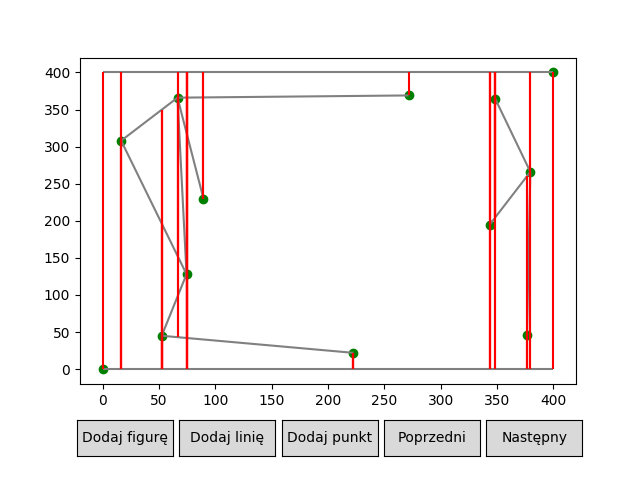

In [157]:
import random
%matplotlib notebook

scenes = []

all_polygons = make_polygons_from_json("polygons_1.json")
all_lines = extract_all_lines(all_polygons)

#all_lines = make_lines_from_json("lines_1.json")
#random.shuffle(all_lines)

left_line = all_lines[0]
for line in all_lines:
    if line.p1.x < left_line.p1.x:
        left_line = line
all_lines.remove(left_line)
all_lines.insert(0, left_line)

roott = Tree().build_tree(all_lines)
roott.print_tree(roott.root)

plot = Plot(scenes)
plot.draw()

